# ResNet

Original Paper Link: https://arxiv.org/abs/1512.03385

## 개요

깊은 네트워크에서 학습시키기 위한 방법으로 잔여 학습(residual learning)을 제안합니다.

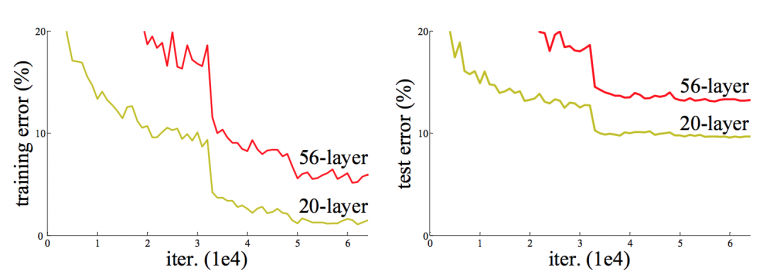

기본적으로 네트워크가 깊어지면 깊어질수록 더욱 더 풍부한 특징들을 데이터로부터 추출해낼 수 있게 되고, 이로 인해 더욱 더 높은 성능을 뽑아 낼 수 있는것이 일반적으로 보여주는 양상이다. 다만, layer가 너무 깊어지면 오히려 성능이 위 그림처럼 떨어지는 것을 확인할 수 있다. 일반적으로 layer를 계속 쌓아 어느 일정 수준부터는 성능이 떨어지는것을 보완하기 위해 잔여 학습을 적용한 CNN(ResNet)을 통해 이러한 문제를 해결할 수 있음을 알 수 있다. 즉, 더 깊은 layer가 더 좋은 성능을 발휘한다는 양상을 그대로 유지할 수 있도록 보인것이다.

## CNN 모델의 특징 맵(Feature Map)



*   **일반적으로** CNN에서 layer가 깊어질수록 채널의 수가 많아지고 너비와 높이가 줄어듭니다.
*   CNN layer의 서로 다른 필터들은 각각 적절한 특징값을 추출하도록 학습된다.




## 잔여 블록(Residual Block)

잔여 블록을 이용하여 네트워크의 최적화(optimmization) 난이도를 낮춥니다.

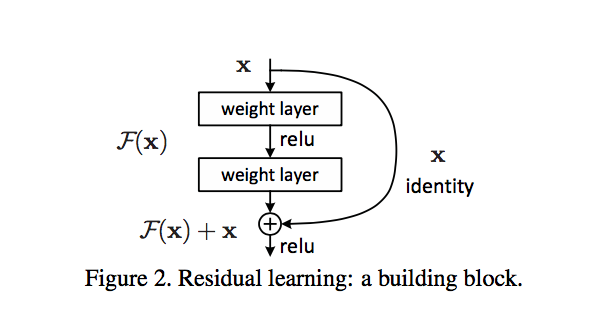

실제로 내재한 mapping인 *H(x)*를 곧바로 학습하기 어려우므로 대신 *F(x) = H(x) - x*를 학습한다.

## ImageNet에서의 결과

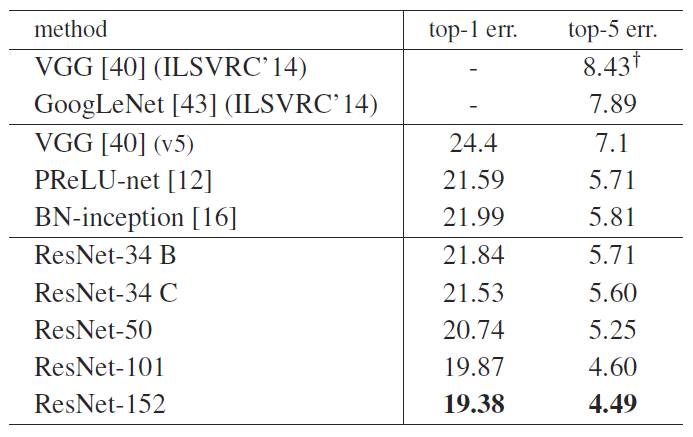

ResNet 이전에 ImageNet에서 우수한 성적을 거둔 VGGNet이나 GoogLeNet에 비해 적은 error rate을 달성한 것을 알 수 있다. 

## ResNet-34 CNN 구현

In [60]:
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

In [69]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,
      keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
      keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
        keras.layers.BatchNormalization()
      ]

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'activation':self.activation,
        'main_layers': self.main_layers,
        'skip_layers':self.skip_layers
    })
    return config
    
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [70]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224,224,3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2,padding="same" ))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))